In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 128)             │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 50, 16)              │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,552 (1006.06 KB)

 Trainable params: 257,552 (1006.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0314 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0029 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0023 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 5/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0019 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0024 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0018 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0017 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 9/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0019 - val_loss: 0.0018 - learning_rate: 0.0010

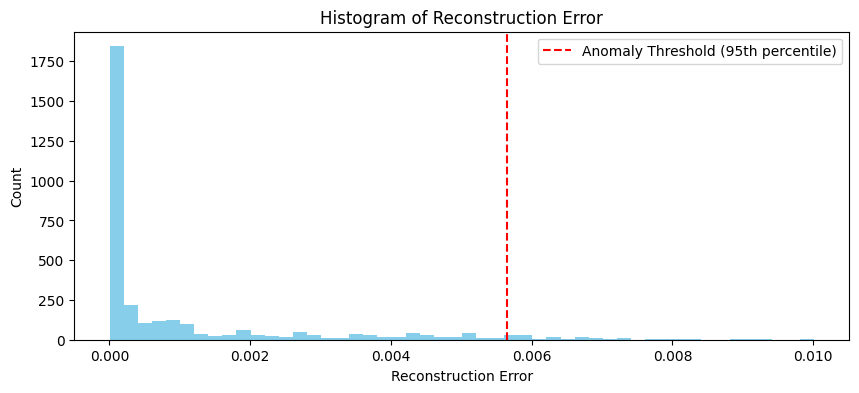

Number of anomalies detected: 163
Mean Error       : 0.0010659926013510122
Std Deviation    : 0.0018555895667734257
Threshold (95%)  : 0.005647103433371399
Anomalies Found  : 163
Total Samples    : 3245


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1. Load the data
df = pd.read_csv('/content/drive/MyDrive/AIdebrief/extracted_data_fixed.csv')  # Replace with your actual dataset

features = ['TAS', 'PTCH', 'ROLL', 'MACH', 'WOW', 'AOA2', 'LATP', 'A_T', 'TRK', 'LOC', 'LATG', 'LONG', 'TAT', 'LGUP', 'LGDN', 'DA']
data = df[features].dropna()

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 3. Create sequences
def create_sequences(data, window_size=50):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 50
X = create_sequences(scaled_data, window_size)

# 4. Split train and test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 5. Build LSTM Autoencoder
timesteps = X.shape[1]
n_features = X.shape[2]

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(128, return_sequences=True)(input_layer)
encoded = LSTM(64)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# 6. Train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr]
)

# 7. Compute reconstruction error
X_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_pred), axis=(1, 2))

# Set threshold before plotting
threshold = np.percentile(reconstruction_error, 95)

# 8. Plot the reconstruction error
plt.figure(figsize=(10, 4))
plt.hist(reconstruction_error, bins=50, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold (95th percentile)')
plt.title("Histogram of Reconstruction Error")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

# 9. Flag anomalies
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

print("Mean Error       :", np.mean(reconstruction_error))
print("Std Deviation    :", np.std(reconstruction_error))
print("Threshold (95%)  :", threshold)
print("Anomalies Found  :", np.sum(anomalies))
print("Total Samples    :", len(reconstruction_error))



In [ ]:
model.save("lstm_model.h5")

testing

In [4]:
# 10. Indexes of anomalies
anomaly_indices = np.where(anomalies)[0]
print("Anomaly indices in test set:", anomaly_indices)


Anomaly indices in test set: [  12   27   43   53   59   61   64   93  196  214  245  262  270  292
  293  345  371  375  387  408  437  455  479  482  514  553  561  562
  564  582  626  644  650  664  675  686  709  744  802  850  851  861
  873  879  911  919  941  946  998 1033 1047 1073 1095 1097 1120 1122
 1129 1172 1173 1229 1244 1247 1327 1340 1362 1367 1368 1383 1403 1411
 1499 1505 1513 1560 1589 1591 1620 1626 1639 1699 1747 1777 1787 1810
 1832 1857 1865 1870 1904 1910 1921 1958 1976 1983 2003 2011 2081 2089
 2098 2116 2120 2133 2142 2143 2161 2162 2221 2246 2259 2281 2285 2306
 2318 2332 2369 2372 2374 2386 2392 2408 2444 2450 2451 2476 2481 2500
 2533 2551 2563 2604 2613 2621 2654 2656 2716 2748 2749 2753 2815 2816
 2825 2830 2866 2889 2904 2912 2921 2932 2943 2998 3022 3023 3046 3069
 3073 3084 3095 3104 3134 3154 3165 3169 3232]


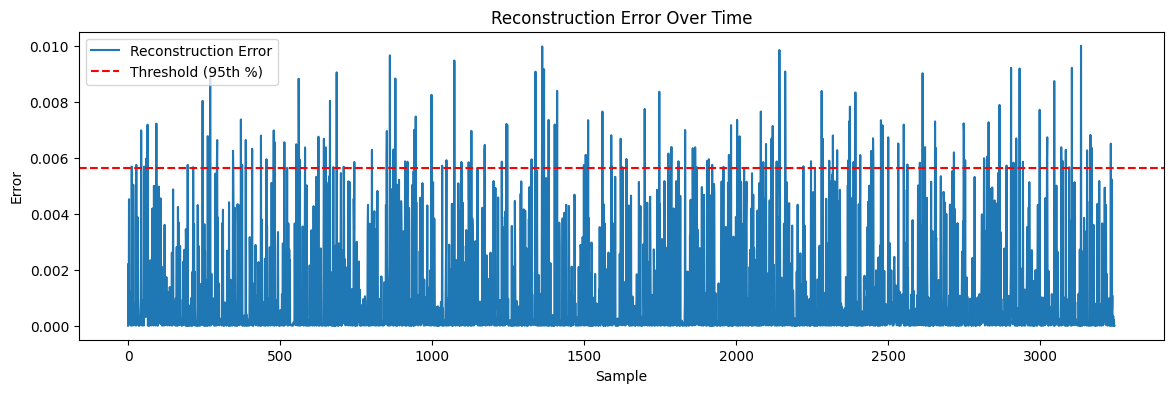

In [5]:
plt.figure(figsize=(14, 4))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold (95th %)')
plt.title("Reconstruction Error Over Time")
plt.xlabel("Sample")
plt.ylabel("Error")
plt.legend()
plt.show()


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.5625e-05
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.5625e-05
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.5625e-05
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.5625e-05
Epoch 5/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.5625e-05
Epoch 6/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.5625e-05
Epoch 7/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 7.8125e-06
Epoch 8/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 7.8125e-06
Epoch 9/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0011 - val_l

creating dataset for testing

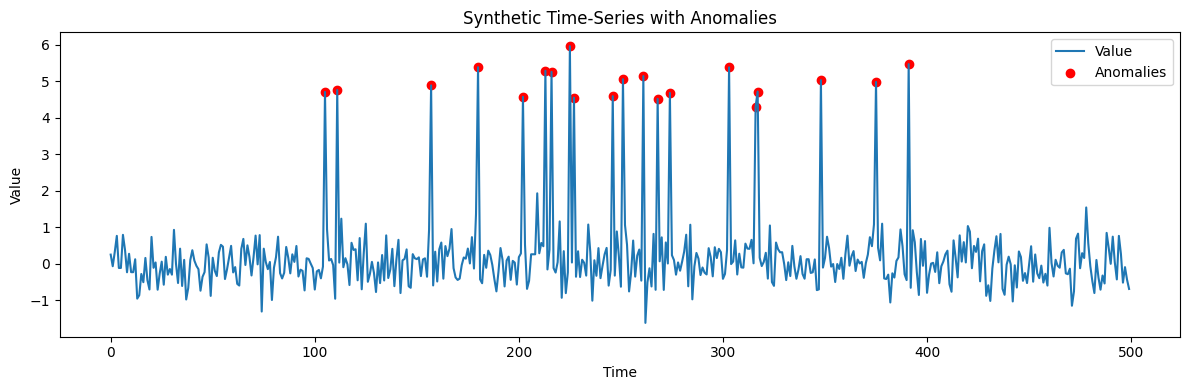

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# Generate normal data
normal_data = np.random.normal(loc=0.0, scale=0.5, size=500)

# Generate anomalies (spikes)
anomalies = np.random.normal(loc=5.0, scale=0.5, size=20)

# Insert anomalies into random positions
data = normal_data.tolist()
anomaly_indices = np.random.choice(range(100, 400), size=20, replace=False)
for idx, anomaly in zip(anomaly_indices, anomalies):
    data[idx] = anomaly

# Ground truth labels
labels = np.zeros(len(data))
labels[anomaly_indices] = 1

# Create DataFrame
df_test = pd.DataFrame({
    'value': data,
    'is_anomaly': labels.astype(int)
})

# Plot the synthetic time-series
plt.figure(figsize=(12, 4))
plt.plot(df_test['value'], label='Value')
plt.scatter(anomaly_indices, df_test['value'][anomaly_indices], color='red', label='Anomalies')
plt.title("Synthetic Time-Series with Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
Accuracy:  1.0000


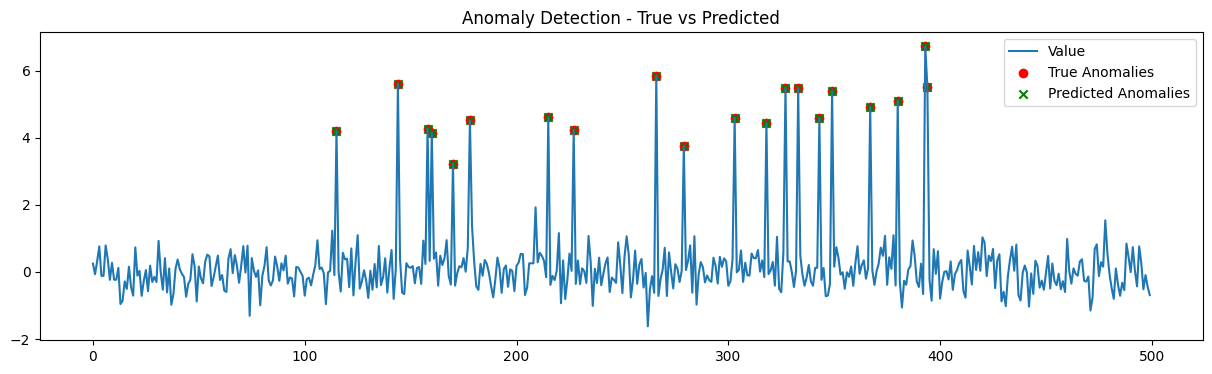

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Step 1: Create synthetic time-series data
np.random.seed(42)
n = 500
data = np.random.normal(0, 0.5, n)

# Step 2: Inject synthetic anomalies at random positions
true_anomalies = np.random.choice(np.arange(100, 400), size=20, replace=False)
data[true_anomalies] += np.random.normal(5, 1, size=20)  # Inject spikes

# Step 3: Simulate model prediction using thresholding
threshold = 3
predicted_anomalies = np.where(data > threshold)[0]

# Step 4: Create label arrays
y_true = np.zeros(n)
y_true[true_anomalies] = 1

y_pred = np.zeros(n)
y_pred[predicted_anomalies] = 1

# Step 5: Calculate performance metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Step 6: Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# Step 7: Plot
plt.figure(figsize=(15, 4))
plt.plot(data, label='Value')
plt.scatter(true_anomalies, data[true_anomalies], color='red', label='True Anomalies')
plt.scatter(predicted_anomalies, data[predicted_anomalies], color='green', marker='x', label='Predicted Anomalies')
plt.title("Anomaly Detection - True vs Predicted")
plt.legend()
plt.show()


In [10]:
!pip install scikit-learn matplotlib numpy

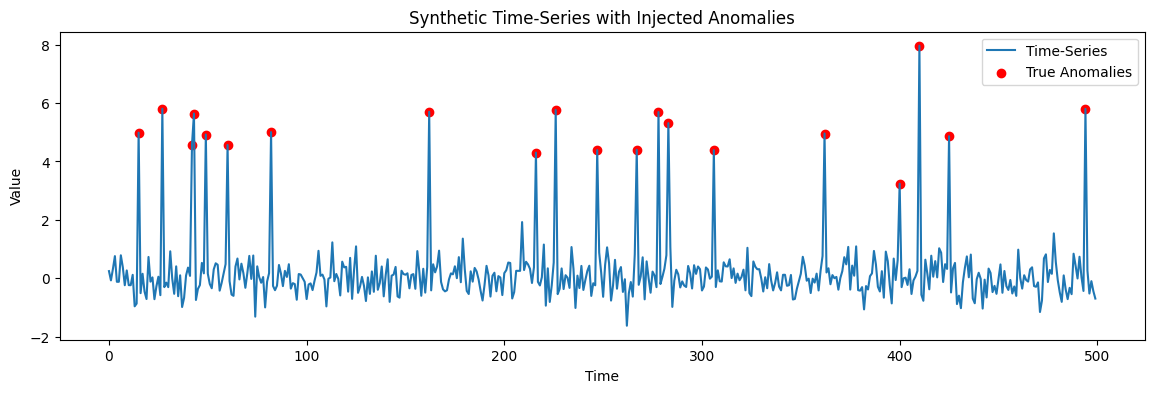

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n = 500
time = np.arange(n)
data = np.random.normal(0, 0.5, size=n)

# Inject synthetic anomalies
anomaly_indices = np.random.choice(n, size=20, replace=False)
data[anomaly_indices] += np.random.normal(5, 1, size=20)  # Inject large spikes

plt.figure(figsize=(14, 4))
plt.plot(time, data, label="Time-Series")
plt.scatter(anomaly_indices, data[anomaly_indices], color="red", label="True Anomalies")
plt.legend()
plt.title("Synthetic Time-Series with Injected Anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [12]:
from sklearn.ensemble import IsolationForest

# Reshape data (IsolationForest expects 2D)
X = data.reshape(-1, 1)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.04, random_state=42)
iso_forest.fit(X)

# Predict anomalies
y_pred = iso_forest.predict(X)  # -1 for anomaly, 1 for normal
predicted_anomalies = np.where(y_pred == -1)[0]


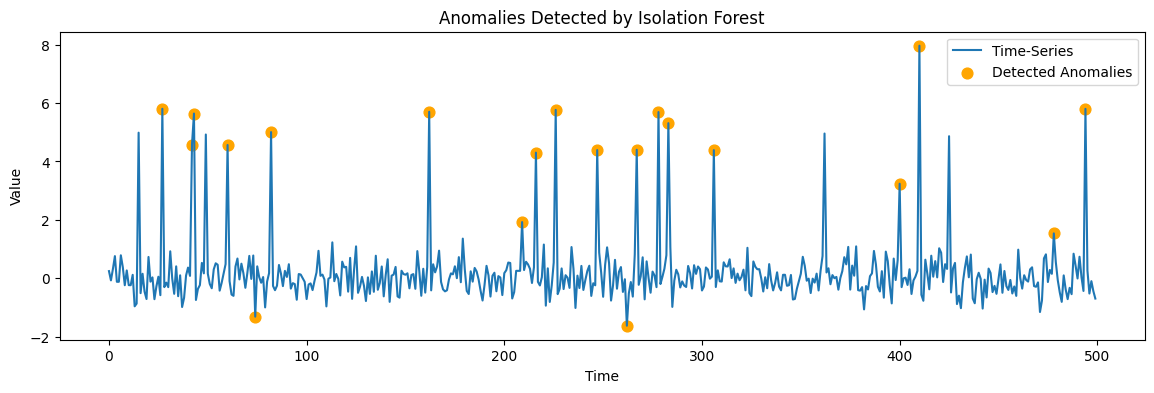

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(time, data, label="Time-Series")
plt.scatter(predicted_anomalies, data[predicted_anomalies], color="orange", label="Detected Anomalies", s=60)
plt.legend()
plt.title("Anomalies Detected by Isolation Forest")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Create binary ground truth and prediction arrays
y_true = np.zeros(n)
y_true[anomaly_indices] = 1

y_pred_bin = np.zeros(n)
y_pred_bin[predicted_anomalies] = 1

# Compute metrics
precision = precision_score(y_true, y_pred_bin)
recall = recall_score(y_true, y_pred_bin)
f1 = f1_score(y_true, y_pred_bin)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Precision: 0.8000
Recall:    0.8000
F1 Score:  0.8000


##testing with real data

In [15]:
# Install required libraries
!pip install pandas numpy matplotlib scikit-learn seaborn


In [18]:
!wget https://raw.githubusercontent.com/Project-NGAFID/ngafid-flights-sample/main/flights/flight_1.csv -O flight_data.csv


--2025-04-06 17:05:36--  https://raw.githubusercontent.com/Project-NGAFID/ngafid-flights-sample/main/flights/flight_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-06 17:05:37 ERROR 404: Not Found.



In [20]:
import pandas as pd

# Load the flight data
df = pd.read_csv('flight_data.csv')

# Show first few rows
df.head()


EmptyDataError: No columns to parse from file

In [25]:
import os

# List all uploaded files
for filename in os.listdir():
    print(filename)


.config
flight_data.csv
drive
flight_1.csv
sample_data


In [26]:
import pandas as pd

# Load the CSV
df = pd.read_csv('sample_flight_data1.csv')

# Display a few rows
df.head()


,Time(s),Altitude(ft),Airspeed(kts),Pitch(deg),Roll(deg),Yaw(deg)
0,0,1202,140,2.0,0.0,0.0
1,1,1205,139,2.2,-0.5,0.1
2,2,1210,142,2.4,1.0,0.2
3,3,1215,140,2.6,-1.5,0.3
4,4,1220,141,2.8,0.0,0.4


In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Altitude'], label='Altitude')
plt.plot(df['Speed'], label='Speed')
plt.legend()
plt.title("Flight Altitude & Speed Over Time")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()


KeyError: 'Altitude'

<Figure size 1200x600 with 0 Axes>

In [28]:
from sklearn.ensemble import IsolationForest

# Select features to detect anomaly
features = df[['Altitude', 'Speed', 'EngineTemp', 'FuelFlow']]

# Fit the model
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)

# Convert -1 to anomaly, 1 to normal
df['is_anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Show result
df[df['is_anomaly'] == 1]


KeyError: "None of [Index(['Altitude', 'Speed', 'EngineTemp', 'FuelFlow'], dtype='object')] are in the [columns]"

In [29]:
print(df.columns)


Index(['Time(s)', 'Altitude(ft)', 'Airspeed(kts)', 'Pitch(deg)', 'Roll(deg)',
       'Yaw(deg)'],
      dtype='object')


In [30]:
Index(['altitude', 'speed', 'engine_temp', 'fuel_flow'], dtype='object')


NameError: name 'Index' is not defined